In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from textblob import TextBlob
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer 
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [4]:
data.head()

,Review,Score
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Check the unique Scores and their value counts in the dataset

In [5]:
data['Score'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Score, dtype: int64

The next step is to remove all the punctuations from the reviews so that the sentiment analysis is done with higher accuracy

In [6]:
data['Review'] = data['Review'].str.replace('[{}]'.format(string.punctuation), '')

In [7]:
data.head()

,Review,Score
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4 experience hotel monaco seatt...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


Removing the stopwords from the dataset because these don't play important role in the sentiment analysis

In [8]:
stops = stopwords.words('english')

In [9]:
data['Review'] = data['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

First of all, we segregate these scores into Positive, Neutral, and Negative reviews. For that, we will have to use the TextBlob library of the Python which will help us to do the sentiment analysis and convert the text sentiments into the polarity value. The polarity ranges from -1 to 1 where -1 represents negative sentiments, 0 represents nuetral sentiments, and 1 represents the positive sentiments.

Next, We will take Score of 4, 5 as Positive, Score of 3 as Neutral, and Score of 1 and 2 as Negative.

In [10]:
ratings = []
for i in range(len(data)):
    rating = TextBlob(data['Review'][i]).polarity
    ratings.append(rating)

In [11]:
data['Polarity'] = ratings

In [12]:
data

,Review,Score,Polarity
0,nice hotel expensive parking got good deal sta...,4,0.208744
1,ok nothing special charge diamond member hilto...,2,0.235193
2,nice rooms 4 experience hotel monaco seattle g...,3,0.294420
3,unique great stay wonderful time hotel monaco ...,5,0.504825
4,great stay great stay went seahawk game awesom...,5,0.471154
...,...,...,...
20486,best kept secret 3rd time staying charm 5star ...,5,0.218320
20487,great location price view hotel great quick pl...,4,0.503704
20488,ok looks nice modern outside desk staff nt par...,2,0.171220
20489,hotel theft ruined vacation hotel opened sept ...,1,0.143280


In [13]:
ratings = [[5], [4,3], [2,1]]

conditions = [(data['Score'] == 1) | (data['Score'] == 2), (data['Score'] == 3), (data['Score'] == 4) | (data['Score'] == 5)]
choices = ['Negative', 'Neutral', 'Positive']

data['Ratings'] = np.select(conditions, choices)

In [14]:
data.head()

,Review,Score,Polarity,Ratings
0,nice hotel expensive parking got good deal sta...,4,0.208744,Positive
1,ok nothing special charge diamond member hilto...,2,0.235193,Negative
2,nice rooms 4 experience hotel monaco seattle g...,3,0.294420,Neutral
3,unique great stay wonderful time hotel monaco ...,5,0.504825,Positive
4,great stay great stay went seahawk game awesom...,5,0.471154,Positive


In [15]:
data.groupby(['Ratings']).size()

Ratings
Negative     3214
Neutral      2184
Positive    15093
dtype: int64

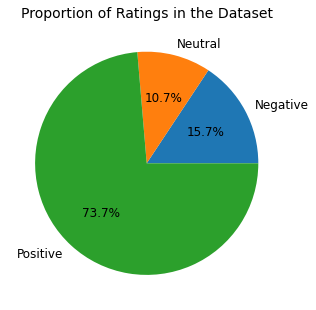

In [16]:
data.groupby(['Ratings']).size().plot(kind = 'pie', autopct = '%1.1f%%', figsize = (5,6), fontsize = 12)
plt.title('Proportion of Ratings in the Dataset', fontsize = 14)
plt.ylabel("")
plt.show()

In [17]:
reviews = list(data['Review'][:5000])

In [18]:
TFIDFv = TfidfVectorizer(use_idf=True)
TFIDFVectors = TFIDFv.fit_transform(reviews)

In [19]:
X = TFIDFVectors.toarray()
y = data['Ratings'][:5000]

Splitting the dataset into training and test dataset

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Training the Logistic Regression model

In [21]:
logisticRegression = LogisticRegression(random_state = 0)
logisticRegression.fit(X_train, y_train)

yPredTrain = logisticRegression.predict(X_train)
yPredTest = logisticRegression.predict(X_test)

In [23]:
print("Training Accuracy score: ", str(round(accuracy_score(y_train, yPredTrain,4))))
print("Testing Accuracy score: ", str(round(accuracy_score(y_test, yPredTest,4))))

print('\n------------------Classification Report-------------------')
print(classification_report(y_test, yPredTest, target_names=['Positive', 'Neutral', 'Negative']))

Training Accuracy score:  1
Testing Accuracy score:  1

------------------Classification Report-------------------
              precision    recall  f1-score   support

    Positive       0.85      0.67      0.75       179
     Neutral       0.75      0.05      0.09       126
    Negative       0.81      0.99      0.89       695

    accuracy                           0.81      1000
   macro avg       0.80      0.57      0.58      1000
weighted avg       0.81      0.81      0.76      1000



### Generating Word Clouds for Positive and Negative reviews

In [24]:
stopwordsList = set(STOPWORDS)
stopwordsList.update(["room", "hotel", "resort", "nt", "day", "night"])

In [25]:
positiveReviews = ' '.join(data[data['Ratings'] == 'Positive']["Review"])
negativeReviews = ' '.join(data[data['Ratings'] == 'Negative']["Review"])

In [26]:
wordcloudPositiveReviews = WordCloud(stopwords = stopwordsList, background_color = "white").generate(positiveReviews)
wordcloudNegativeReviews = WordCloud(stopwords = stopwordsList, background_color = "white").generate(negativeReviews)

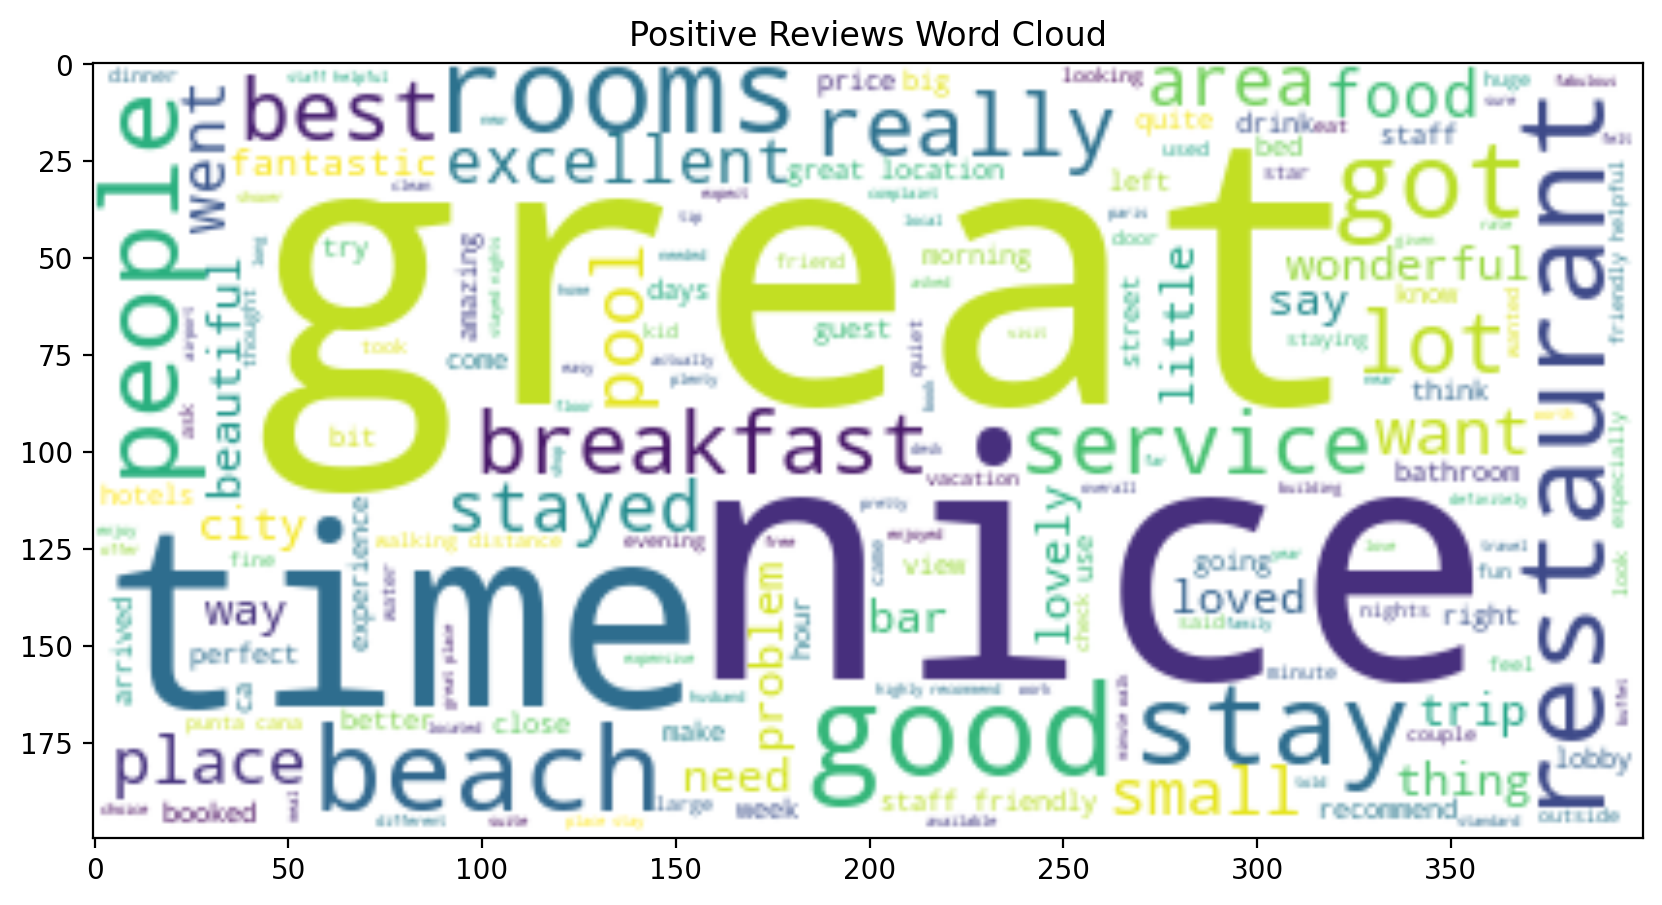

In [27]:
plt.figure(figsize = (10,8), dpi = 200)
plt.imshow(wordcloudPositiveReviews, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.show()

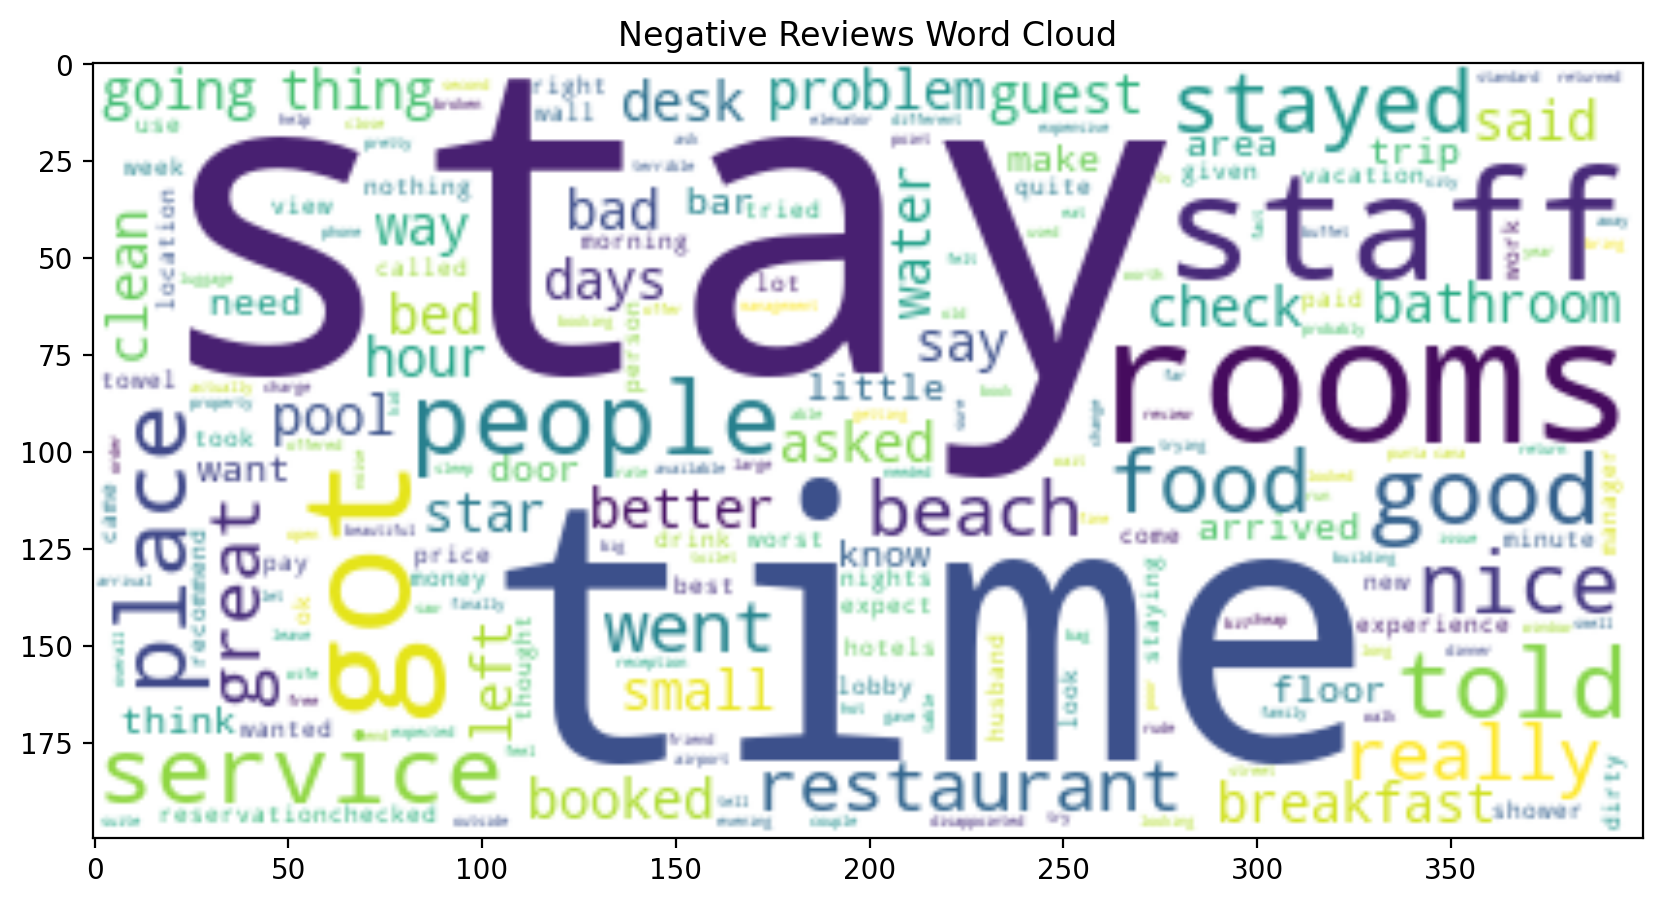

In [28]:
plt.figure(figsize = (10,8), dpi = 200)
plt.imshow(wordcloudNegativeReviews, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.show()